In [1]:
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import time
import sys
import os
import h5py
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import torch.nn as nn 
import torch.optim as optim
from torchnet.dataset import ListDataset, BatchDataset
from torchnet.dataset.dataset import Dataset
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from version_model.model_list import *
from model_structure import save_model_structure
from plotting import plottingLossAcc, roc, Significance, Draw_Eff_Sig, CnnOutputs
from save_log import save_log

In [2]:
bins = {}
# normtype : minmax or std
normtype = 'minmax'
for i in range(1,9):
    bins[i] = np.load("/home/jua/SWGO/square/data/{}/bin/bin{}.npz".format(normtype, i))    

In [3]:
nGevent = [0,83300, 41659, 19998, 8087, 3174, 1004, 272, 32, 0]
nPevent = [0,81720, 42929, 21366, 8932, 3419, 1035, 182, 9, 0]

In [4]:
n = 6
images = bins[n]['image'][:]

images = torch.tensor(images).float()
labels = torch.cat((torch.ones(nGevent[n]),torch.zeros(nPevent[n])))
#labels = torch.tensor(labels).float()

sets = [(images[i],labels[i]) for i in range(len(labels))]
shuffle(sets)

In [5]:
train_sets = sets[:int(len(sets)*0.7)]
valid_sets = sets[int(len(sets)*0.7):int(len(sets)*0.85)]
test_sets = sets[int(len(sets)*0.85):]

In [6]:
batchsize = 128
trainloader = torch.utils.data.DataLoader(train_sets, batch_size=batchsize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_sets, batch_size=batchsize, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_sets, batch_size=batchsize, shuffle=True, num_workers=2)
dataloader = {'train':trainloader, 'valid':validloader, 'test':testloader}
datasize = {'train': len(train_sets), 'valid':len(valid_sets), 'test':len(test_sets)}

In [7]:
print('# of Train : {}, # of valid : {}, # of Test : {}'.format(datasize['train'],datasize['valid'],datasize['test']))

# of Train : 1427, # of valid : 306, # of Test : 306


In [8]:
def augmentation(i, images):
    if i == 0:
        for i in range(len(images)):
            for j in range(4):
                images[i][j] = torch.flip(images[i][j],[0])
        return images
    elif i == 1:
        for i in range(len(images)):
            for j in range(4):
                images[i][j] = torch.flip(images[i][j],[1])
        return images
    elif i == 2:
        for i in range(len(images)):
            for j in range(4):
                images[i][j] = torch.rot90(images[i][j],1)
        return images
    elif i == 3:
        for i in range(len(images)):
            for j in range(4):
                images[i][j] = torch.rot90(images[i][j],2)
        return images
    elif i == 4:
        for i in range(len(images)):
            for j in range(4):
                images[i][j] = torch.rot90(images[i][j],3)
        return images
    else:
        return images

In [9]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        # print('Reset parameters of Linear')
        m.reset_parameters()

def freeze_conv(m):
    if isinstance(m, nn.Conv2d):
        # print('Freeze parameters of Conv2d')
        m.weight.requires_grad = False
        if m.bias is not None:
            m.bias.requires_grad = False

In [10]:
net = Model5()
net = nn.DataParallel(net)
if n > 9:
    net.load_state_dict(torch.load("save_model/best/best_B1_51220200527-151056.pth"))  
    net.apply(weight_init)
    net.apply(freeze_conv)

device=torch.device('cuda')
net.to(device)
net.eval()

DataParallel(
  (module): Model5(
    (layer1): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13

In [11]:
learning_rate = 0.00001
# if sgd :learning_rate = 0.00003
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1,verbose=True,patience=14)

In [12]:
threshold = 0.5
inputsize = 4
classes = {0:'proton',1:'gamma'}

In [13]:
def train_model(net, dataloader, criterion, optimizer, scheduler, n, batchsize, num_epochs=1, device=torch.device('cuda')):
    
    since = time.time()
    best_net_wts = net.state_dict()
    best_acc = 0.0
    threshold = 0.5
    losses = {'train':[],'valid':[]}
    accuracy = {'train':[],'valid':[]}
    
    for epoch in range(num_epochs):
        print( )
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train':
                net.train(True)
            else:
                net.eval()
                
            running_loss = 0.0
            running_corrects= 0
            ep_running_loss = 0.0
            ep_running_corrects = 0
            device = torch.device('cuda')
            for i, data in enumerate(dataloader[phase]):
                inputs, labels = data[0].to(device), data[1].to(device)
                if phase=='train':
                    optimizer.zero_grad()
                    inputs = augmentation(i%6, inputs)
                logits = net(inputs)
                outputs = logits.sigmoid()
                #outputs = net(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs>threshold
                loss = criterion(logits, labels.view(-1,1).float())
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                                       
                running_loss += loss.data
                ep_running_loss += loss.data
                target = labels.view(-1,1)>threshold
                running_corrects += torch.sum(preds==target)
                ep_running_corrects += torch.sum(preds==target)
                               
                # Tensor Board 
                n_times = 10
                if i%n_times==9:
                    writer.add_scalar('{} loss'.format(phase),
                                     running_loss/(n_times),
                                     epoch*len(dataloader[phase])+i)
                    writer.add_scalar('{} Accuracy'.format(phase),
                                     float(running_corrects)/(n_times*batchsize),
                                     epoch*len(dataloader[phase])+i)                  
                    running_loss = 0.0
                    running_corrects = 0
                
            writer.close()
            epoch_loss = float(ep_running_loss)/float(len(dataloader[phase]))
            epoch_acc = float(ep_running_corrects)/float(datasize[phase])
            losses[phase].append(epoch_loss)
            accuracy[phase].append(epoch_acc)
            #if epoch%6==0:
            print('{} Loss: {:.4f}, Acc : {:.4f}'.format( phase, epoch_loss, epoch_acc))    
            if phase == 'valid':
                scheduler.step(losses['valid'][-1])
                #scheduler.step()
            if phase=='valid' and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_net_wts = net.state_dict()
        
    print()
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Acc: {:4f}".format(best_acc))
    net.load_state_dict(best_net_wts)
    if best_acc > 0.9:
        modellogdir = "save_model/best/best_B{}_512".format(n) + now.strftime("%Y%m%d-%H%M%S") + ".pth"
        torch.save(net.state_dict(), modellogdir)
        save_log(losses, accuracy, num_epochs, n)
        save_model_structure(net, '5')
    return net,losses,accuracy,best_acc 

In [14]:
def test(testloader,batchsize,device=torch.device('cuda')):
    correct = 0
    total = 0
    y_score = np.array([])
    y = np.array([])
    test_losses = []
    outs = []
    labs = []
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        labels = labels.view(-1,1)
        logits = net(inputs)
        outputs = logits.sigmoid()
        preds = outputs>threshold     
        loss = criterion(logits, labels.view(-1,1).float())
        y_score = np.append(y_score,outputs.data.cpu().detach().numpy())
        y = np.append(y,labels.cpu().numpy())
        test_losses.append(loss.data/batchsize)
        total += labels.size(0)
        target = labels.view(-1,1)>threshold
        correct += torch.sum(preds==target)
        outs.append(outputs.data.cpu().detach().numpy())
        labs.append(labels.data.cpu().detach().numpy()) 
    return y, y_score, correct, total, test_losses, outs, labs

In [15]:
from datetime import datetime
now = datetime.now()
logdir = "runs/bin{}/".format(n) + now.strftime("%Y%m%d-%H%M%S") + "/"
writer = SummaryWriter(logdir)
ep = 200
net,losses,accuracy,best_acc = train_model(net, dataloader, criterion, optimizer,exp_lr_scheduler, n, batchsize, ep)


Epoch 0/199
----------
train Loss: 0.6884, Acc : 0.5284
valid Loss: 0.6938, Acc : 0.5098

Epoch 1/199
----------
train Loss: 0.6706, Acc : 0.6293
valid Loss: 0.7001, Acc : 0.5098

Epoch 2/199
----------
train Loss: 0.6622, Acc : 0.6664
valid Loss: 0.6740, Acc : 0.5458

Epoch 3/199
----------
train Loss: 0.6418, Acc : 0.7176
valid Loss: 0.6381, Acc : 0.7614

Epoch 4/199
----------
train Loss: 0.6205, Acc : 0.7652
valid Loss: 0.6131, Acc : 0.8072

Epoch 5/199
----------
train Loss: 0.5981, Acc : 0.8031
valid Loss: 0.5892, Acc : 0.8170

Epoch 6/199
----------
train Loss: 0.5823, Acc : 0.8087
valid Loss: 0.5669, Acc : 0.8333

Epoch 7/199
----------
train Loss: 0.5553, Acc : 0.8248
valid Loss: 0.5446, Acc : 0.8399

Epoch 8/199
----------
train Loss: 0.5324, Acc : 0.8374
valid Loss: 0.5066, Acc : 0.8562

Epoch 9/199
----------
train Loss: 0.5086, Acc : 0.8535
valid Loss: 0.4912, Acc : 0.8693

Epoch 10/199
----------
train Loss: 0.4879, Acc : 0.8528
valid Loss: 0.4675, Acc : 0.8758

Epoch 11

valid Loss: 0.1475, Acc : 0.9542

Epoch 90/199
----------
train Loss: 0.1138, Acc : 0.9755
valid Loss: 0.1273, Acc : 0.9542

Epoch 91/199
----------
train Loss: 0.1413, Acc : 0.9720
valid Loss: 0.1271, Acc : 0.9510

Epoch 92/199
----------
train Loss: 0.1077, Acc : 0.9692
valid Loss: 0.1379, Acc : 0.9510

Epoch 93/199
----------
train Loss: 0.1104, Acc : 0.9699
valid Loss: 0.1215, Acc : 0.9542

Epoch 94/199
----------
train Loss: 0.1041, Acc : 0.9713
valid Loss: 0.1178, Acc : 0.9510

Epoch 95/199
----------
train Loss: 0.1030, Acc : 0.9755
valid Loss: 0.1319, Acc : 0.9510

Epoch 96/199
----------
train Loss: 0.1009, Acc : 0.9741
valid Loss: 0.1196, Acc : 0.9510

Epoch 97/199
----------
train Loss: 0.1041, Acc : 0.9720
valid Loss: 0.1271, Acc : 0.9510

Epoch 98/199
----------
train Loss: 0.1115, Acc : 0.9699
valid Loss: 0.1171, Acc : 0.9510

Epoch 99/199
----------
train Loss: 0.1095, Acc : 0.9664
valid Loss: 0.1211, Acc : 0.9510

Epoch 100/199
----------
train Loss: 0.1115, Acc : 0.969

valid Loss: 0.1249, Acc : 0.9542

Epoch 178/199
----------
train Loss: 0.1007, Acc : 0.9748
valid Loss: 0.1155, Acc : 0.9542

Epoch 179/199
----------
train Loss: 0.1005, Acc : 0.9783
valid Loss: 0.1427, Acc : 0.9510

Epoch 180/199
----------
train Loss: 0.1249, Acc : 0.9692
valid Loss: 0.1276, Acc : 0.9542

Epoch 181/199
----------
train Loss: 0.1047, Acc : 0.9706
valid Loss: 0.1266, Acc : 0.9575

Epoch 182/199
----------
train Loss: 0.1042, Acc : 0.9727
valid Loss: 0.1183, Acc : 0.9575

Epoch 183/199
----------
train Loss: 0.0997, Acc : 0.9748
valid Loss: 0.1209, Acc : 0.9510

Epoch 184/199
----------
train Loss: 0.1026, Acc : 0.9755
valid Loss: 0.1220, Acc : 0.9510

Epoch 185/199
----------
train Loss: 0.1033, Acc : 0.9776
valid Loss: 0.1275, Acc : 0.9542

Epoch 186/199
----------
train Loss: 0.1112, Acc : 0.9713
valid Loss: 0.1307, Acc : 0.9575

Epoch 187/199
----------
train Loss: 0.1099, Acc : 0.9755
valid Loss: 0.1302, Acc : 0.9510

Epoch 188/199
----------
train Loss: 0.1017, A

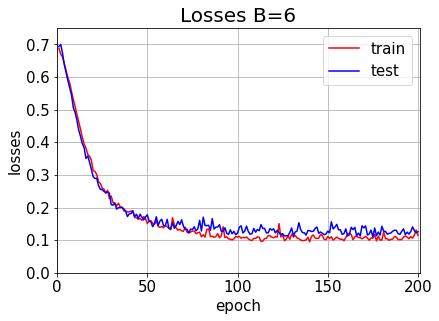

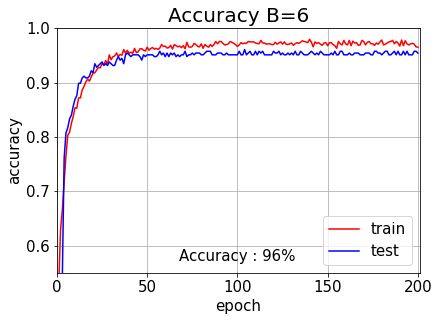

In [16]:
plottingLossAcc(losses,accuracy, n,(0,len(losses['train'])+1,0,0.75),(0,len(accuracy['train'])+1,0.55,1.0),int(best_acc*100),ep)

In [17]:
y,y_score,correct,total,test_losses,outputs,labels = test(dataloader['test'],batchsize)

Accuracy of the network on the 306 test images: 98 %


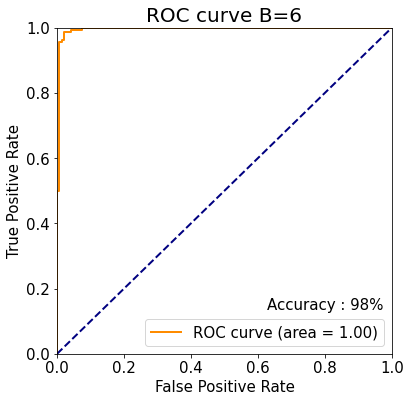

In [18]:
fpr, tpr, thresholds = roc(y,y_score,correct,total,n)

In [19]:
new, s = Significance(thresholds, outputs, labels)

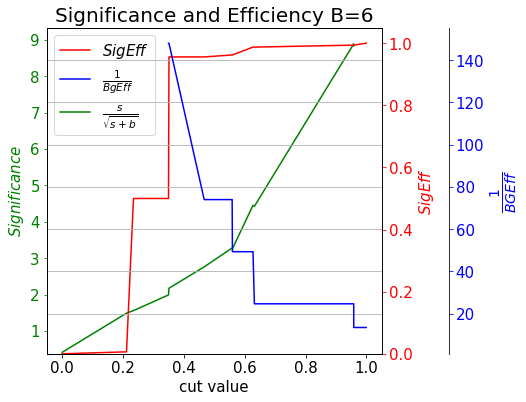

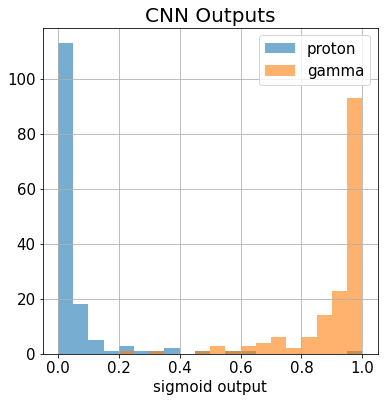

In [20]:
Draw_Eff_Sig(1/fpr[fpr!=0], tpr, s, thresholds, new, n)
CnnOutputs(outputs, labels, n)